# Imports and helper functions

In [ ]:
import torch
import scipy
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from types import SimpleNamespace
from tqdm import tqdm

# Set seeds for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def normalize(x, axis=0):
    """ Normalize input across given axis. """
    x_max = np.max(x, axis=axis, keepdims=True)
    x_min = np.min(x, axis=axis, keepdims=True)
    return (x-x_min)/(x_max-x_min)

def split(x, perc=0.2):
    """ Split input into train/test subsets. """
    x = np.random.permutation(x)
    return x[int(len(x)*perc):], x[:int(len(x)*perc)]

def log_likelihood(y_pred, y_true):
    """ Loss function. """
    r = torch.pow(y_pred, y_true)
    r = torch.prod(r, axis=1)
    return -torch.sum(torch.log(r))

class ChoiceDataset(torch.utils.data.Dataset):
    """ Formats dataset in PyTorch's standard. """
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## NN Models in Pytorch

In [ ]:
class LogitLayer(nn.Sequential):
    """ Standard mother logit layer """
    def __init__(self, n_attrs, n_units, dropout_rate):
        super(LogitLayer, self).__init__(
            nn.Linear(n_attrs, n_units),
            nn.LayerNorm(n_units),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

class HAVANLayer(nn.Module):
    """ Implements our method. This is the layer where magic happens. """
    def __init__(self, n_moments, n_draws=1024):
        super(HAVANLayer, self).__init__()
        sobol_uniform = torch.tensor(scipy.stats.qmc.Sobol(n_moments, scramble=True).random(n_draws)).float()
        self.draws = torch.pow(sobol_uniform, torch.arange(n_moments)).to(device)

    def forward(self, x):
        u = torch.einsum("npjk,rk -> npjr", x, self.draws)
        exp_u = torch.exp(u)
        probabilities = exp_u/torch.sum(exp_u, axis=2, keepdim=True)
        mean_probabilities = torch.mean(probabilities, axis=3)
        return mean_probabilities

class NN(nn.Module):
    """ Network that integrates all the components. """
    def __init__(self, n_alts, n_attrs, config, use_havan=True):
        super(NN, self).__init__()
        self.logit_layer = LogitLayer(n_attrs, config.n_units, config.dropout_rate)
        self.layers = nn.Sequential(*[LogitLayer(config.n_units, config.n_units, config.dropout_rate) \
                                      for _ in range(config.n_layers)])
        self.moments = nn.Linear(config.n_units, config.n_moments)
        if use_havan:
            self.output = HAVANLayer(config.n_moments)
        else:
            self.output = nn.Sequential(nn.Flatten(2, 3),
                                        nn.Linear(config.n_moments*n_alts, n_alts),
                                        nn.Softmax(dim=-1))

    def forward(self, x):
        # x shape: (n_obs, n_panels, n_alts, n_attrs)
        x = self.logit_layer(x)
        x = self.layers(x)
        x = F.leaky_relu(self.moments(x))
        x = self.output(x)
        return x

## Generate data

We use the data generation process shown below:

$$
        \begin{equation}
            u_{ijk} = \beta_{i0}^{x_0}+x_1 e^{\beta_{i1}} +x_2\beta_{i2} + \epsilon_{ijk}
        \end{equation}
$$

$$
        \begin{equation}
            \begin{split}
                \beta_{i0} &\sim Uniform(1,2) \\
                \begin{bmatrix}
                    \beta_{i1} \\
                    \beta_{i2} \\
                \end{bmatrix}
                &\sim
                 Normal \left(\begin{bmatrix} 0 \\3 \end{bmatrix}, \begin{bmatrix} 0.5 & 0.25 \\ 0.25 & 1 \end{bmatrix} \right)
                \\
                x_0, x_1, x_2  &\sim Uniform(-1,1)
            \end{split}
        \end{equation}
$$

Additionally, $\beta_{i2}$ has a 50\% chance of being negated, thus $\beta_{i2}$ is a mixture of two normal distribution (i.e. is bi-modal)

In [ ]:
def generate_dataset(n_indiv=10_000, n_attr=3, n_alt=3, n_panels=10):
    mu = np.array([0.0, 3.0])
    omega = np.array([[0.5, .25], [.25, 1.0]])

    # Generate coefficients
    coeff = np.hstack((np.random.uniform(low=1, high=2, size=(n_indiv, 1)),
                       np.random.multivariate_normal(mu, omega, n_indiv)))

    negated_idx = np.random.choice(n_indiv, n_indiv//2, replace=False)
    coeff[:, 2][negated_idx] *= -1

    # Generate x_i data
    X = np.random.uniform(low=-1, high=1, size=(n_indiv*n_panels*n_alt, n_attr))
    X = X.reshape(n_indiv, n_panels, n_alt, n_attr)

    # Compute utilities
    V = (np.power(coeff[:, None, None, 0], X[:, :, :, 0]) +
         X[:, :, :, 1]*np.exp(coeff[:, None, None, 1]) +
         X[:, :, :, 2]*coeff[:, None, None, 2])

    # Compute probabilities
    eV = np.exp(V)
    proba = eV/eV.sum(axis=2, keepdims=True)

    # Simulate Choices
    y = np.apply_along_axis(lambda p: np.random.choice(n_alt, p=p), 1, proba.reshape(-1, n_alt))
    y = (np.eye(n_alt)[y]).reshape(n_indiv, n_panels, n_alt)
    return X, y

def split_dataset(X, y, eval_perc=.2):
    train_idx, eval_idx = split(np.arange(len(X)), perc=eval_perc)
    return X[train_idx], X[eval_idx], y[train_idx], y[eval_idx]

# Training function

In [ ]:
def train(model, train_data, eval_data, n_epochs, lr, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size)
    eval_loader = DataLoader(eval_data, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train': [], 'eval': []}
    for epoch in tqdm(range(n_epochs)):
        # Training
        model.train()
        for batch in train_loader:
            X_batch, y_batch = [d.to(device) for d in batch]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = log_likelihood(outputs, y_batch)
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            history['train'].append({'epoch': epoch,'loss': loss.item()})

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in eval_loader:
                X_batch, y_batch = [d.to(device) for d in batch]
                outputs = model(X_batch)
                loss = log_likelihood(outputs, y_batch)
                history['eval'].append({'epoch': epoch, 'loss': loss.item()})
    return history

# Run robustness test

In [ ]:
n_trials = 20
n_indiv = 10_000
n_attr = 3
n_alt = 3
n_panels = 10
n_epochs = 2_000
device = 'cuda:0'
config = SimpleNamespace(**dict(n_layers=2, n_units=64, n_moments=6, dropout_rate=0.25, lr=1e-3))

history_classic, history_havan = [], []
for i in range(n_trials):
    X, y = generate_dataset(n_indiv=n_indiv, n_attr=n_attr, n_alt=n_alt, n_panels=n_panels)
    X_train, X_eval, y_train, y_eval = split_dataset(X, y)
    train_data, eval_data = ChoiceDataset(X_train, y_train), ChoiceDataset(X_eval, y_eval)

    model = NN(n_alts=n_alt, n_attrs=n_attr, config=config, use_havan=True).to(device)
    history = train(model, train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=len(y_eval))
    history_havan.append(history)

    model = NN(n_alts=n_alt, n_attrs=n_attr, config=config, use_havan=False).to(device)
    history = train(model, train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=len(y_eval))
    history_classic.append(history)

100%|██████████| 2000/2000 [01:05<00:00, 30.76it/s]


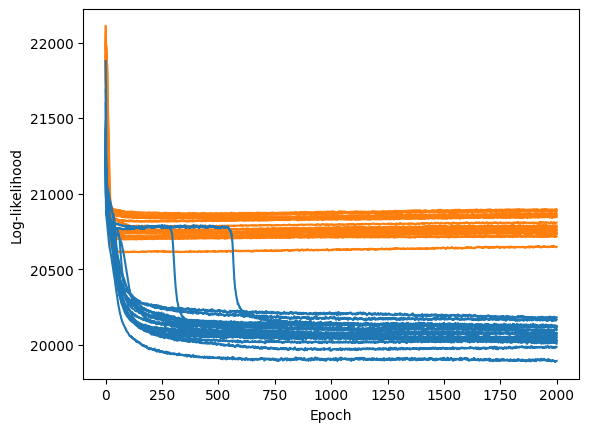

In [ ]:
import matplotlib.pyplot as plt
for h in history_classic:
    plt.plot([x['loss'] for x in h['eval']], 'tab:orange')

for h in history_havan:
    plt.plot([x['loss'] for x in h['eval']], 'tab:blue')

plt.xlabel("Epoch")
plt.ylabel("Log-likelihood")
plt.show()